<a href="https://colab.research.google.com/github/usamasafdarvirk/A_Deep_Learning_Approach_to_Precise_MRI_Brain_Tumor_Diagnosis/blob/main/MRI_Image_Classification_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Required Libraries

In [ ]:
import os  # Module for interacting with the operating system (e.g., file and directory operations)
from PIL import Image  # Module for opening, manipulating, and saving many different image file formats
import numpy as np  # Library for numerical operations on large, multi-dimensional arrays and matrices
import pandas as pd  # Library for data manipulation and analysis, providing data structures and operations for manipulating numerical tables and time series
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations in Python
import seaborn as sns  # Library for making statistical graphics in Python, built on top of matplotlib
from glob import glob  # Module for finding all the pathnames matching a specified pattern according to the rules used by the Unix shell
#---------------------------------------
from sklearn.model_selection import train_test_split  # Function for splitting arrays or matrices into random train and test subsets
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
#---------------------------------------
import tensorflow as tf  # Library for high-performance numerical computation and machine learning
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Utility for generating batches of tensor image data with real-time data augmentation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
#---------------------------------------
import warnings  # Module for controlling the warnings filter
warnings.filterwarnings("ignore")  # Suppress warnings from appearing in the output


# Importing the Images form Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def create_train_dataframe(train_directory):
    """
    Creates a DataFrame containing image paths and their corresponding class labels from the specified training directory.

    Parameters:
    train_directory (str): Directory path containing subdirectories of images, with each subdirectory named after its class label.

    Returns:
    pd.DataFrame: A DataFrame with two columns - 'Image Path' and 'Label'.
    """
    class_labels, image_paths = zip(*[
        (folder_name, os.path.join(train_directory, folder_name, image_file))
        for folder_name in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, folder_name))
        for image_file in os.listdir(os.path.join(train_directory, folder_name))
    ])

    train_dataframe = pd.DataFrame({'Image Path': image_paths, 'Label': class_labels})
    return train_dataframe

def create_test_dataframe(test_directory):
    """
    Creates a DataFrame containing image paths and their corresponding class labels from the specified test directory.

    Parameters:
    test_directory (str): Directory path containing subdirectories of images, with each subdirectory named after its class label.

    Returns:
    pd.DataFrame: A DataFrame with two columns - 'Image Path' and 'Label'.
    """
    class_labels, image_paths = zip(*[
        (folder_name, os.path.join(test_directory, folder_name, image_file))
        for folder_name in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, folder_name))
        for image_file in os.listdir(os.path.join(test_directory, folder_name))
    ])

    test_dataframe = pd.DataFrame({'Image Path': image_paths, 'Label': class_labels})
    return test_dataframe


In [ ]:
train_data = create_train_dataframe('/content/drive/MyDrive/MRI Brain Tumor Dataset/Training')
train_data

,Image Path,Label
0,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
1,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
2,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
3,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
4,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
...,...,...
5707,/content/drive/MyDrive/MRI Brain Tumor Dataset...,glioma
5708,/content/drive/MyDrive/MRI Brain Tumor Dataset...,glioma
5709,/content/drive/MyDrive/MRI Brain Tumor Dataset...,glioma
5710,/content/drive/MyDrive/MRI Brain Tumor Dataset...,glioma


In [ ]:
test_data = create_test_dataframe('/content/drive/MyDrive/MRI Brain Tumor Dataset/Testing')
test_data

,Image Path,Label
0,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
1,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
2,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
3,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
4,/content/drive/MyDrive/MRI Brain Tumor Dataset...,pituitary
...,...,...
1306,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma
1307,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma
1308,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma
1309,/content/drive/MyDrive/MRI Brain Tumor Dataset...,meningioma


# Distribution of Images in Each Class

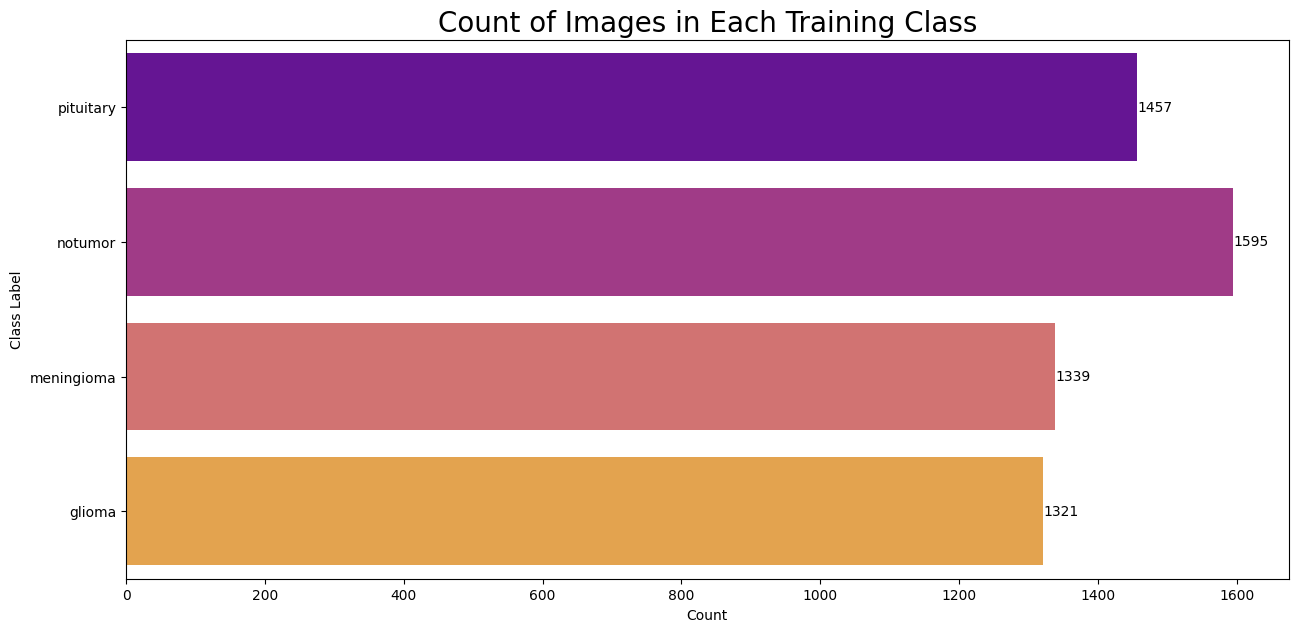

In [ ]:
def plot_label_distribution(dataframe, column_name, plot_title, color_palette='coolwarm'):
    """
    Plots the count of images in each class in the provided DataFrame.

    Parameters:
    dataframe (pd.DataFrame): DataFrame containing the class labels.
    column_name (str): Name of the column containing class labels.
    plot_title (str): Title of the plot.
    color_palette (str): Color palette to use for the plot (default is 'coolwarm').

    Returns:
    None
    """
    plt.figure(figsize=(15, 7))
    ax = sns.countplot(data=dataframe, y=column_name, palette=color_palette)

    plt.xlabel('Count')
    plt.ylabel('Class Label')
    plt.title(plot_title, fontsize=20)

    # Adding the labels to the bars
    for container in ax.containers:
        ax.bar_label(container)

    plt.show()


plot_label_distribution(train_data, 'Label', 'Count of Images in Each Training Class', color_palette='plasma')


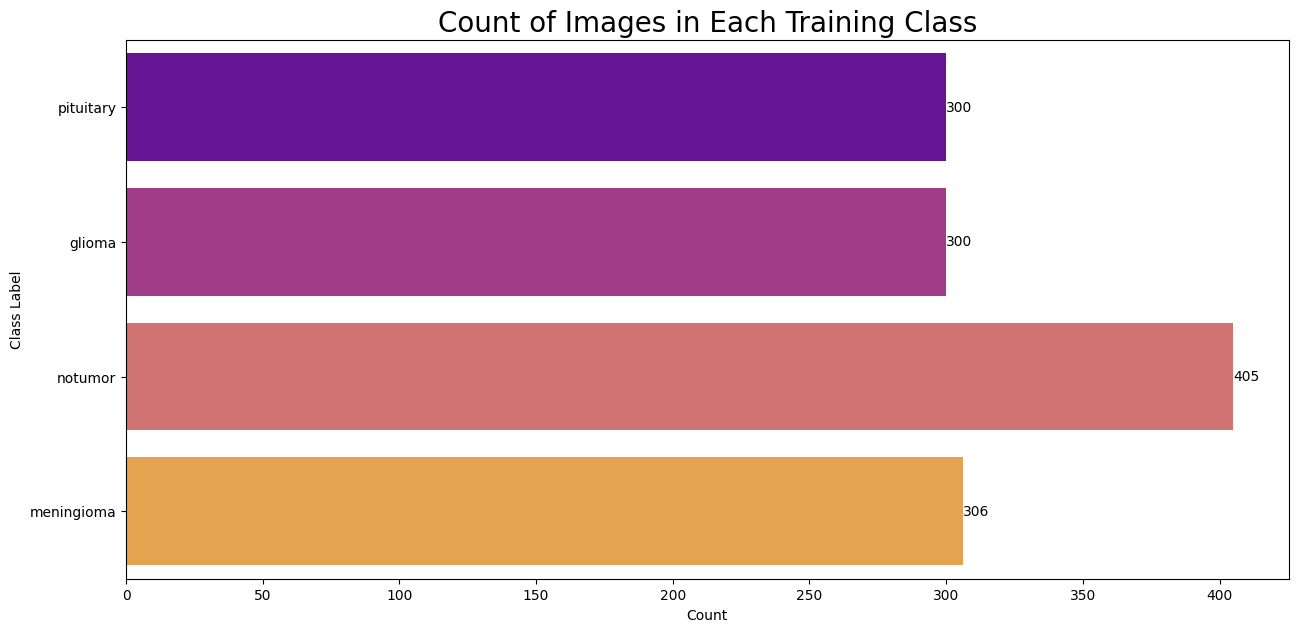

In [ ]:
plot_label_distribution(test_data, 'Label', 'Count of Images in Each Training Class', color_palette='plasma')

# Spliting the Imges to Train and Test Set

In [ ]:
valid_data, test_data = train_test_split(test_data, train_size=0.5, random_state=20, stratify=test_data['Label'])

# Image Preprocessing -Data Augmentation

In [ ]:
# Parameters
batch_size = 32  # Number of images to be yielded from the generator per batch
img_size = (150, 150)  # Target size for each image
brightness_range = (0.8, 1.2)  # Range for random brightness adjustment
rescale_factor = 1/255  # Rescaling factor for the images

# Create ImageDataGenerators with parameters
train_val_gen = ImageDataGenerator(
    rescale=rescale_factor,
    brightness_range=brightness_range,
)

# ImageDataGenerator for test set (only rescaling)
test_gen = ImageDataGenerator(rescale=rescale_factor,
                              brightness_range=brightness_range,)

# Function to create generators from dataframes
def create_generators(tr_df, valid_df, ts_df, batch_size, img_size):
    """
    Creates training, validation, and test data generators from dataframes.

    Parameters:
    tr_df (pd.DataFrame): DataFrame containing training data.
    valid_df (pd.DataFrame): DataFrame containing validation data.
    ts_df (pd.DataFrame): DataFrame containing test data.
    batch_size (int): Number of images to be yielded from the generator per batch.
    img_size (tuple): Target size for each image.

    Returns:
    tuple: Training, validation, and test data generators.
    """
    if tr_df.empty or valid_df.empty or ts_df.empty:
        raise ValueError("One of the dataframes is empty. Please check your dataframes.")

    # Training data generator
    train_gen = train_val_gen.flow_from_dataframe(
        tr_df,
        x_col='Image Path',
        y_col='Label',
        batch_size=batch_size,
        target_size=img_size
    )

    # Validation data generator
    valid_gen = train_val_gen.flow_from_dataframe(
        valid_df,
        x_col='Image Path',
        y_col='Label',
        batch_size=batch_size,
        target_size=img_size
    )

    # Test data generator
    test_gen_flow = test_gen.flow_from_dataframe(
        ts_df,
        x_col='Image Path',
        y_col='Label',
        batch_size=16,
        target_size=img_size,
        shuffle=False
    )

    return train_gen, valid_gen, test_gen_flow

train_gen_data, valid_gen_data, test_gen_flow_data = create_generators(train_data, valid_data, test_data, batch_size, img_size)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# Augmented Images

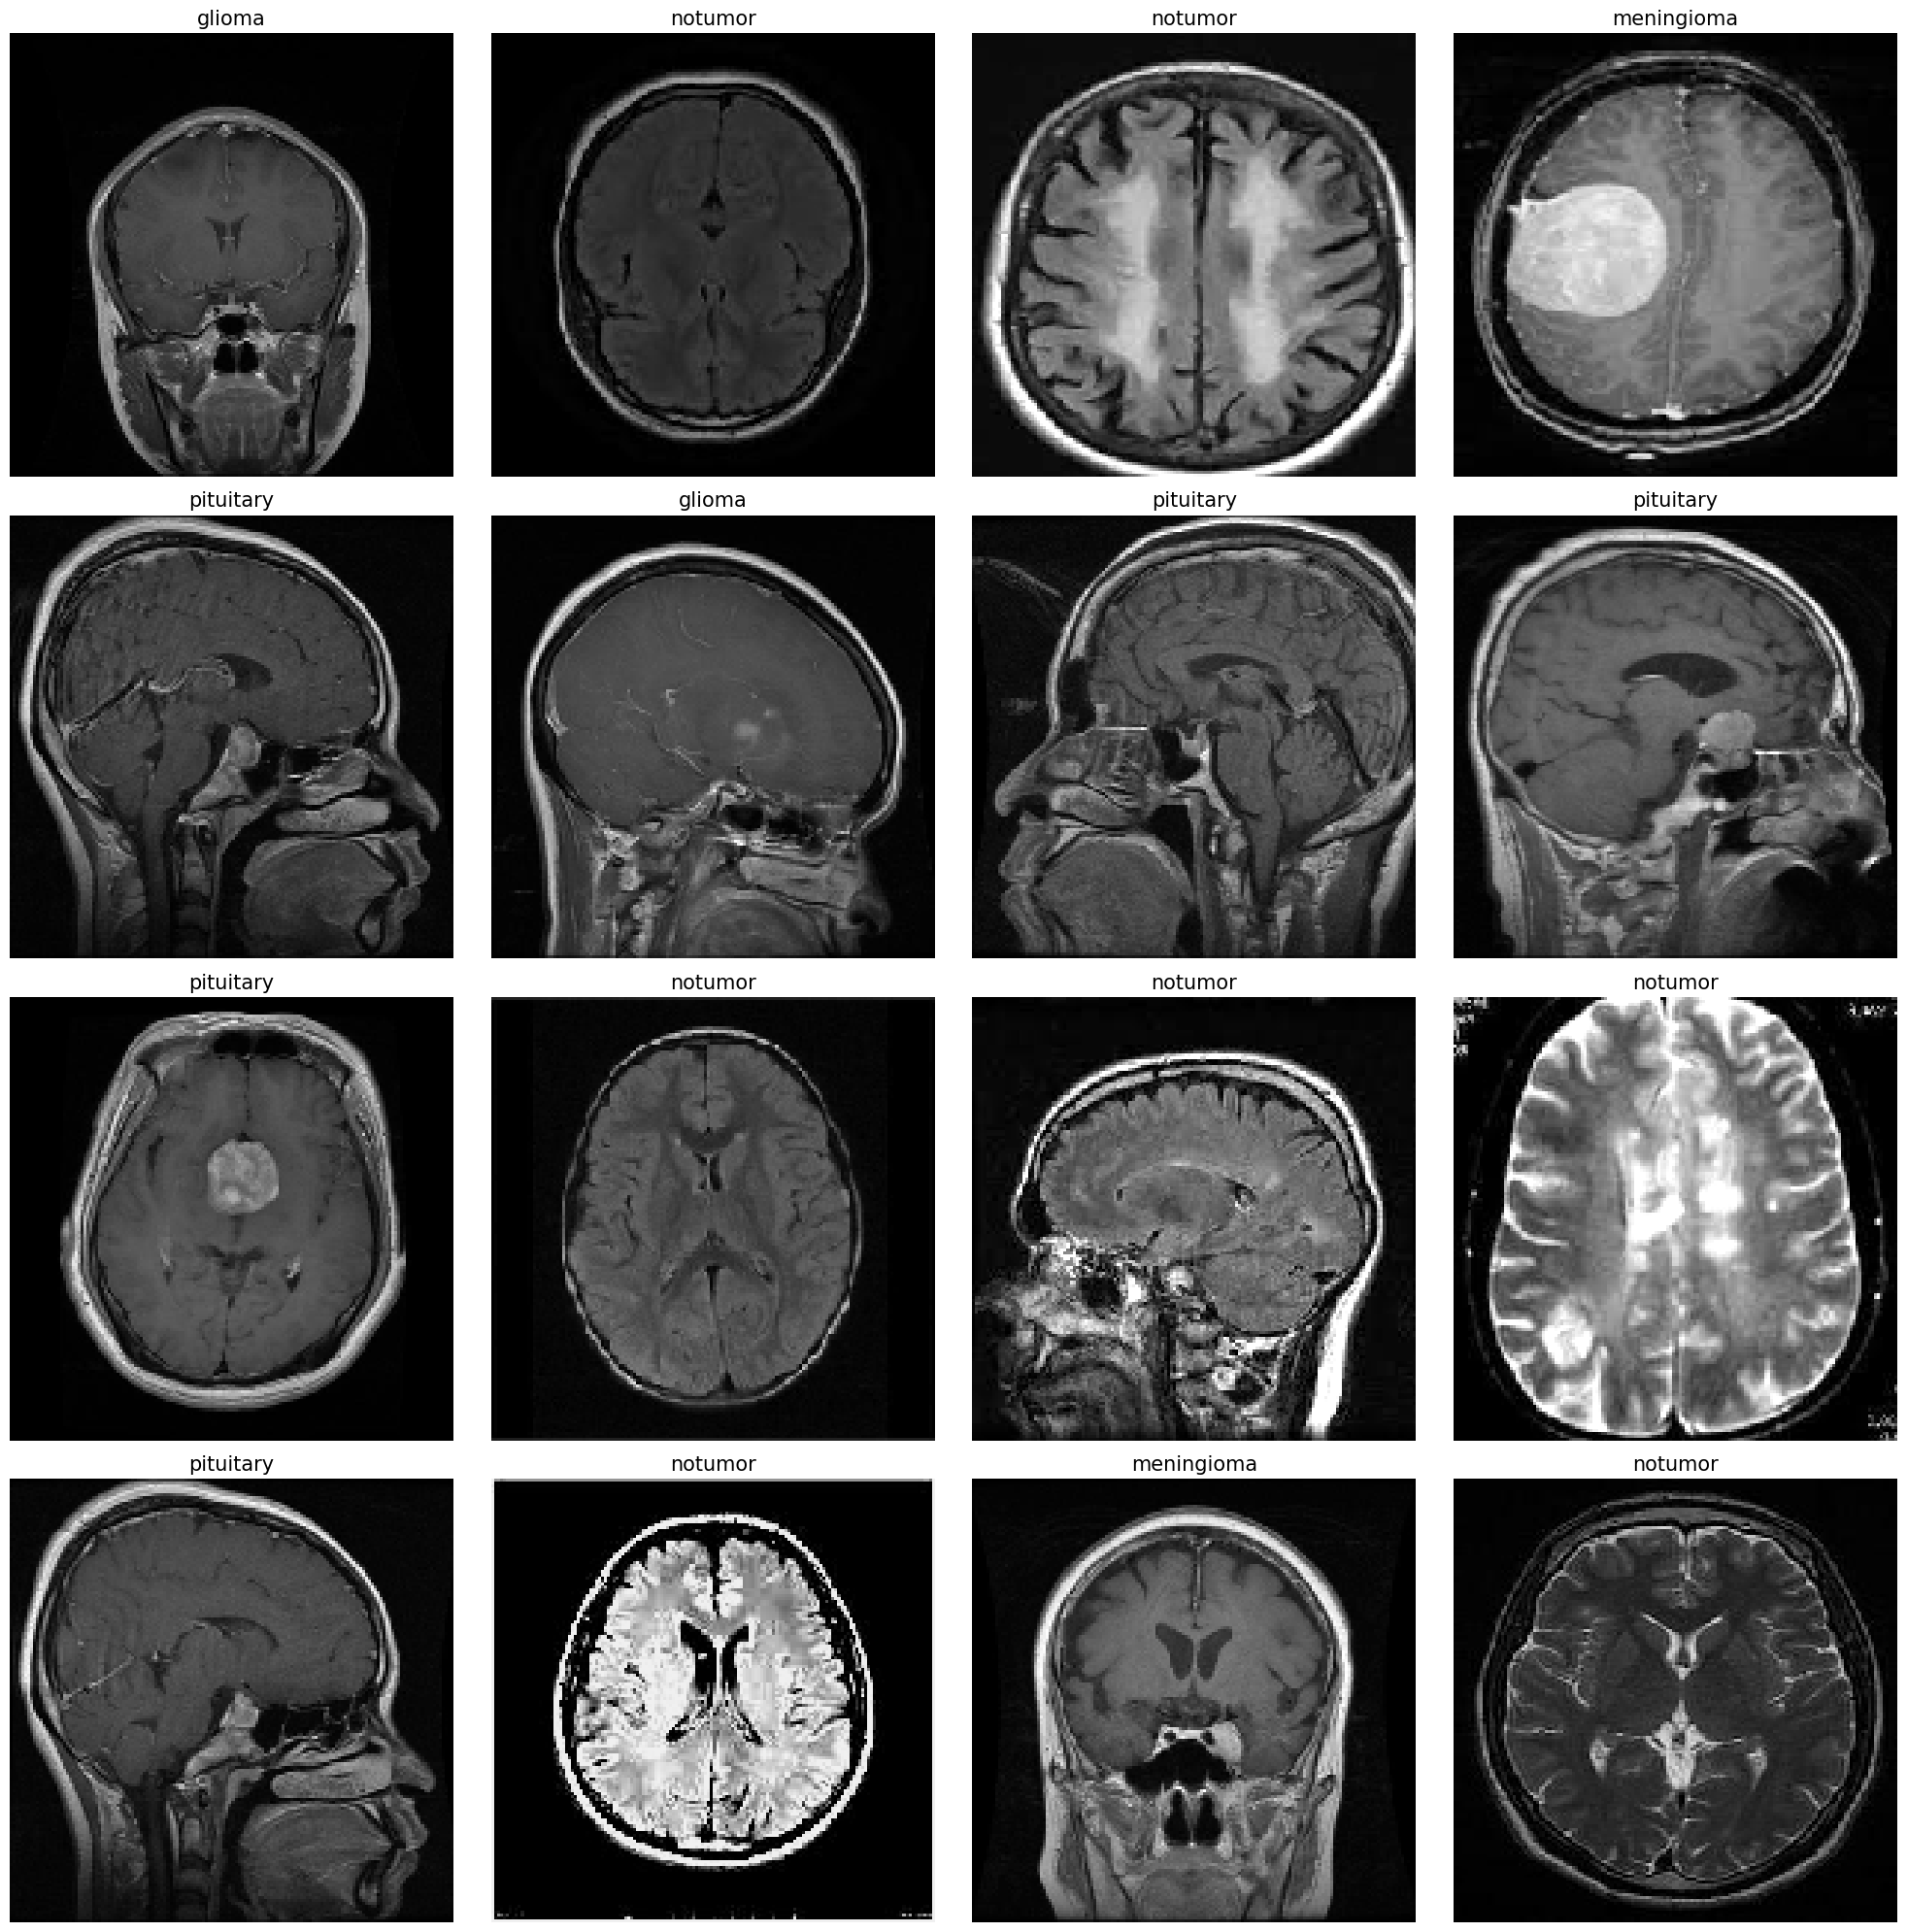

In [ ]:
def show_image_batch(data_generator, label_mapping, batch_size=16, grid_size=(4, 4), figsize=(20, 20)):
    """
    Displays a batch of images and their corresponding class labels from the given data generator.

    Parameters:
    data_generator (tf.keras.preprocessing.image.DirectoryIterator): The data generator to fetch images and labels from.
    label_mapping (dict): A dictionary mapping class names to their corresponding indices.
    batch_size (int): Number of images to display in the batch (default is 16).
    grid_size (tuple): The size of the grid for displaying images (default is (4, 4)).
    figsize (tuple): The size of the figure for the plot (default is (20, 20)).

    Returns:
    None
    """
    # Create a list of class names from the dictionary keys
    class_names = list(label_mapping.keys())
    # Fetch the next batch of images and labels from the data generator
    images, labels = next(data_generator)

    # Set the figure size for the plot
    plt.figure(figsize=figsize)

    # Iterate over the images and their corresponding labels
    for i, (image, label) in enumerate(zip(images, labels)):
        if i >= batch_size:
            break
        # Create a subplot in the grid
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        # Display the image
        plt.imshow(image)
        # Find the index of the highest value in the one-hot encoded label
        class_name = class_names[np.argmax(label)]
        # Set the title of the subplot to the class name
        plt.title(class_name, color='k', fontsize=15)
        plt.axis('off')  # Turn off axis

    # Display the figure with all subplots
    plt.tight_layout()
    plt.show()

# Example usage
label_dict = train_gen_data.class_indices
show_image_batch(train_gen_data, label_dict)


# Designing CNN Archtecture

In [ ]:
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

model = Sequential([
    # Block 1
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu",
           kernel_regularizer=l2(0.001), input_shape=img_shape),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu",
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Block 2
    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu",
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu",
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Block 3
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu",
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu",
           kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Block 4
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu",
           kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu",
           kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Block 5
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu",
           kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu",
           kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation="relu", kernel_regularizer=l2(0.002)),
    Dropout(0.5),
    Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(4, activation="softmax")
])


# Compiling the Model

In [ ]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 10,202,436 (38.92 MB)

 Trainable params: 10,197,572 (38.90 MB)

 Non-trainable params: 4,864 (19.00 KB)

# Training the Network

In [ ]:
epochs = 30   # number of all epochs in training
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
history = model.fit(train_gen_data,
                    epochs=epochs,
                    validation_data=valid_gen_data,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 1863s 10s/step - accuracy: 0.5359 - loss: 8.3055 - val_accuracy: 0.2290 - val_loss: 9.2635 - learning_rate: 0.0010
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 216ms/step - accuracy: 0.7326 - loss: 6.5097 - val_accuracy: 0.3863 - val_loss: 7.1342 - learning_rate: 0.0010
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 233ms/step - accuracy: 0.7599 - loss: 6.1856 - val_accuracy: 0.3481 - val_loss: 8.2847 - learning_rate: 0.0010
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 229ms/step - accuracy: 0.8107 - loss: 5.7558 - val_accuracy: 0.6733 - val_loss: 5.8404 - learning_rate: 0.0010
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 239ms/step - accuracy: 0.8439 - loss: 5.4258 - val_accuracy: 0.7298 - val_loss: 5.4325 - learning_rate: 0.0010
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 234ms/step - accuracy: 0.8445 - loss: 5.1144 - val_accuracy: 0.7466 - val_loss: 5.2193 - learning_rate: 0.0010
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - accuracy: 0.8

# Results of CNN Training

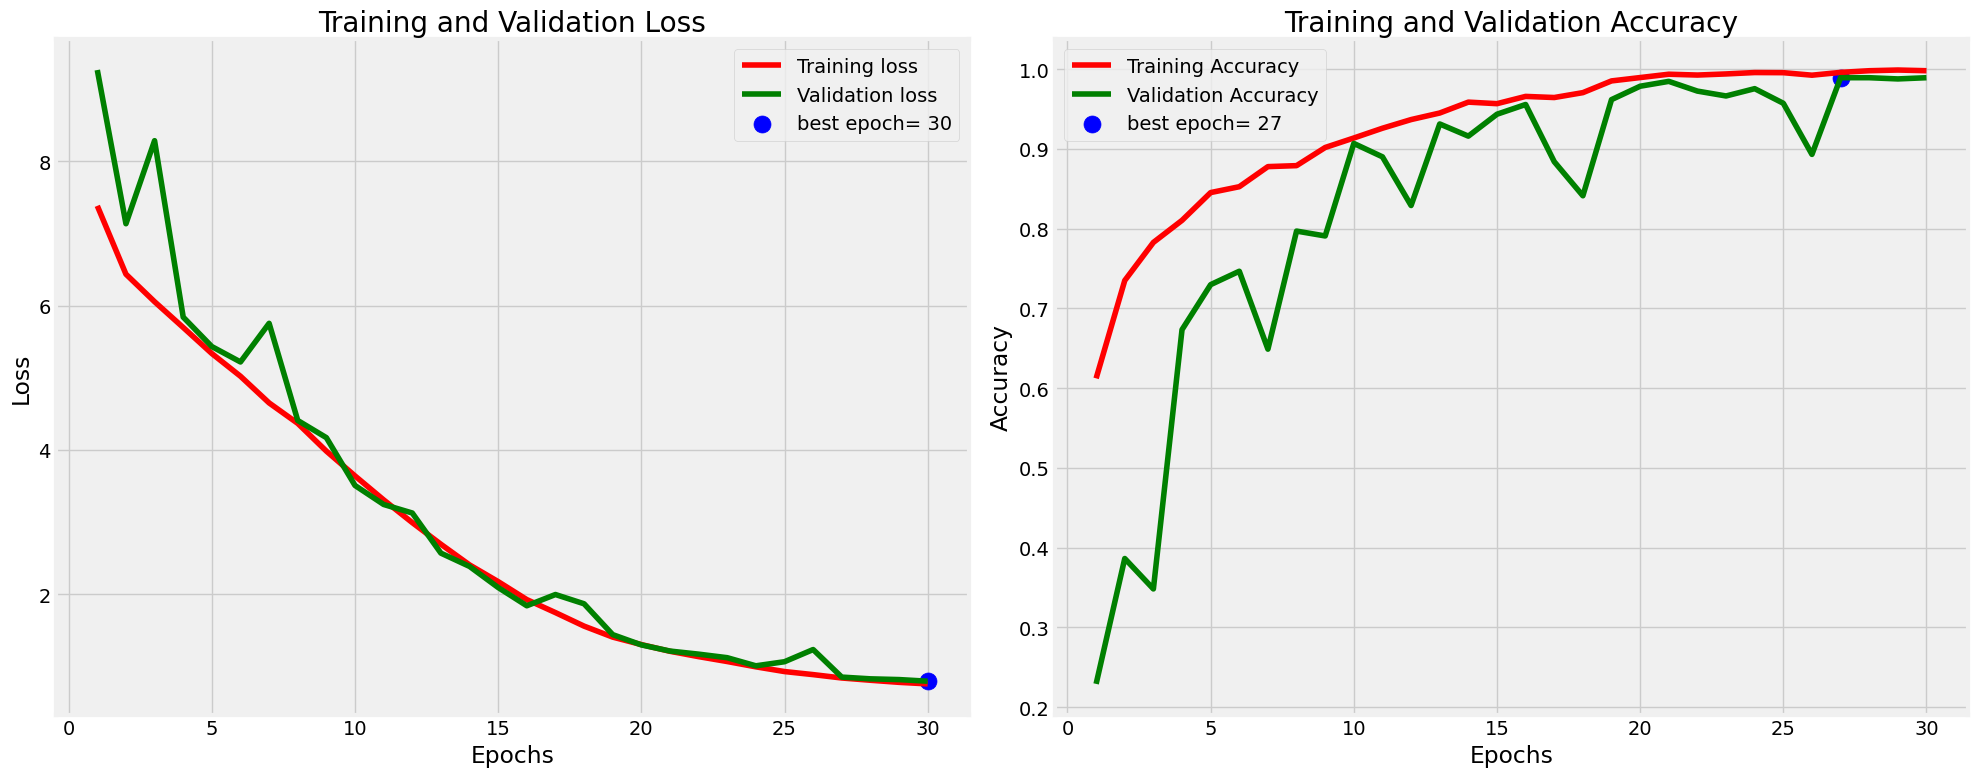

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy for each epoch from the training history.

    Parameters:
    history (History): The history object returned by the `model.fit()` method.

    Returns:
    None: Displays the plots.
    """
    # Extract accuracy and loss for training and validation sets
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Find the best epochs for loss and accuracy
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Prepare epochs list
    Epochs = [i + 1 for i in range(len(tr_acc))]

    # Labels for best epochs
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Plot for loss
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for accuracy
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_training_history(history)

# Evaluating the Model

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen_flow_data, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict on the test set
test_pred = model.predict(test_gen_flow_data)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = test_gen_flow_data.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 218s 5s/step - accuracy: 0.9861 - loss: 0.7824
Test Loss: 0.7796481251716614
Test Accuracy: 0.9878048896789551
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


# Confusion Matrix

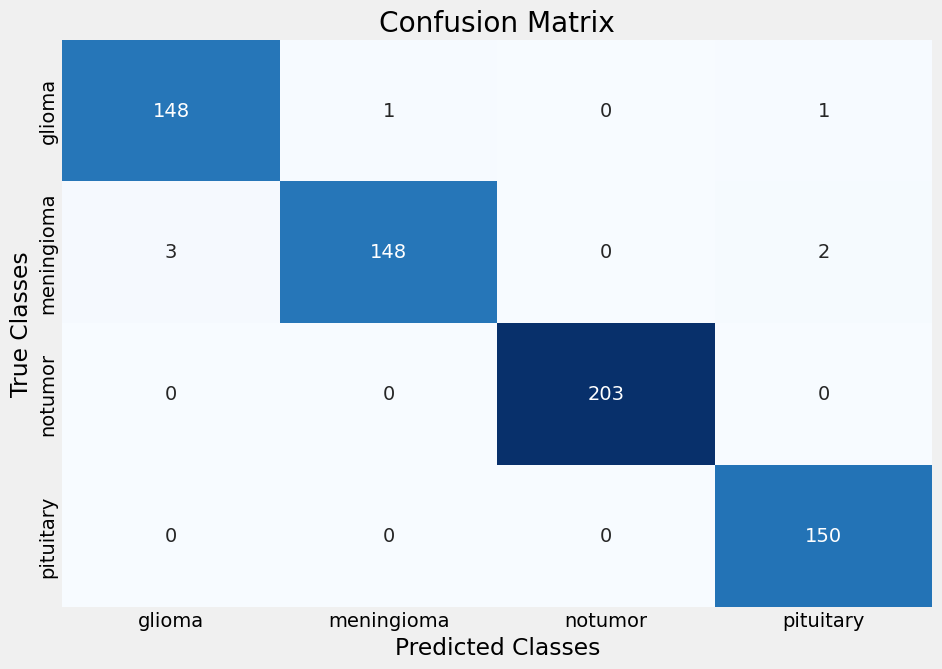

In [ ]:
# Get class names
class_names = list(test_gen_flow_data.class_indices.keys())
# Generate the confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

# Classification Report

In [ ]:
# Generate the classification report
report = classification_report(test_true_classes, test_pred_classes)

# Display the classification report
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       150
           1       0.99      0.97      0.98       153
           2       1.00      1.00      1.00       203
           3       0.98      1.00      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



# ROC Curve

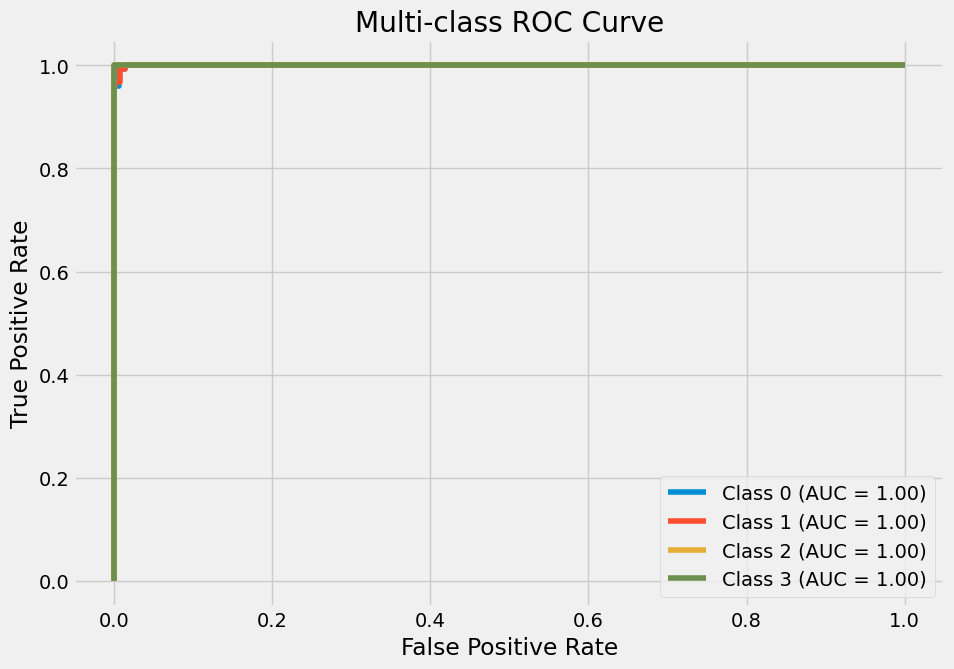

In [ ]:
# Assuming you have the true labels and predicted probabilities
n_classes = test_pred.shape[1]  # Number of classes

# Binarize the true labels for multi-class ROC curve
test_true_binarized = label_binarize(test_true_classes, classes=range(n_classes))

# Plot the ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_binarized[:, i], test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {i}').plot(ax=plt.gca())

plt.title('Multi-class ROC Curve')
plt.show()

# Save the Model

In [ ]:
model.save('CNN_my_Best_01.h5')

# Transfer Learning

In [ ]:
# Load the pre-trained Xception model without the top layers
xception_base = Xception(weights='imagenet', include_top=False, input_shape=img_shape)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Build the Model

In [ ]:
# Build the model
model = Sequential([
    xception_base,
    Flatten(),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation="softmax")  # Output layer with softmax activation
])

# Compile the model

In [ ]:
# Compile the model
model.compile(Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks

In [ ]:
# Define callbacks for early stopping, learning rate reduction, and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

# Train the Model

In [ ]:
# Train the model
history = model.fit(train_gen_data, epochs=30, verbose=1, validation_data=valid_gen_data, shuffle=False,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 151s 498ms/step - accuracy: 0.5993 - loss: 1.1419 - val_accuracy: 0.7771 - val_loss: 0.5777 - learning_rate: 1.0000e-04
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 53s 294ms/step - accuracy: 0.8398 - loss: 0.4351 - val_accuracy: 0.8183 - val_loss: 0.4823 - learning_rate: 1.0000e-04
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 58s 321ms/step - accuracy: 0.9007 - loss: 0.2947 - val_accuracy: 0.8855 - val_loss: 0.3436 - learning_rate: 1.0000e-04
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 256ms/step - accuracy: 0.9240 - loss: 0.2209 - val_accuracy: 0.9176 - val_loss: 0.1986 - learning_rate: 1.0000e-04
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 248ms/step - accuracy: 0.9520 - loss: 0.1402 - val_accuracy: 0.9450 - val_loss: 0.1308 - learning_rate: 1.0000e-04
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 248ms/step - accuracy: 0.9675 - loss: 0.1118 - val_accuracy: 0.9695 - val_loss: 0.0935 - learning_rate: 1.0000e-04
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 2

# Training Curves

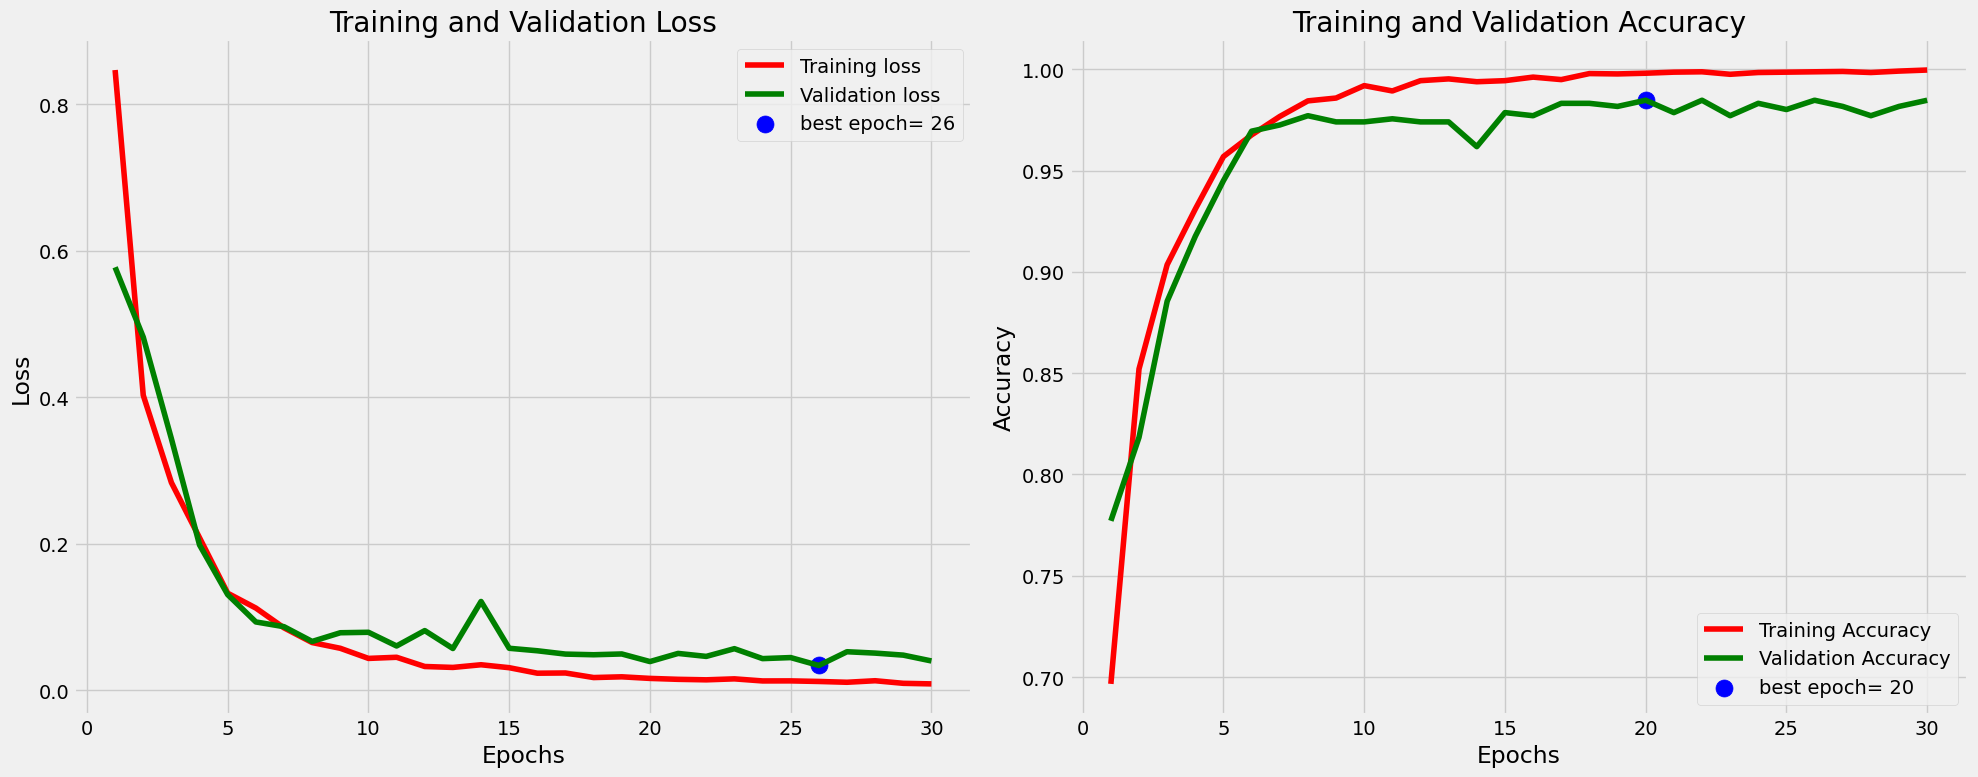

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy for each epoch from the training history.

    Parameters:
    history (History): The history object returned by the `model.fit()` method.

    Returns:
    None: Displays the plots.
    """
    # Extract accuracy and loss for training and validation sets
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Find the best epochs for loss and accuracy
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Prepare epochs list
    Epochs = [i + 1 for i in range(len(tr_acc))]

    # Labels for best epochs
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Plot for loss
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for accuracy
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_training_history(history)

# Model Evaluation

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen_flow_data, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict on the test set
test_pred = model.predict(test_gen_flow_data)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = test_gen_flow_data.classes


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9970 - loss: 0.0155
Test Loss: 0.033688463270664215
Test Accuracy: 0.9908536672592163
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step


# Confusion Matrix

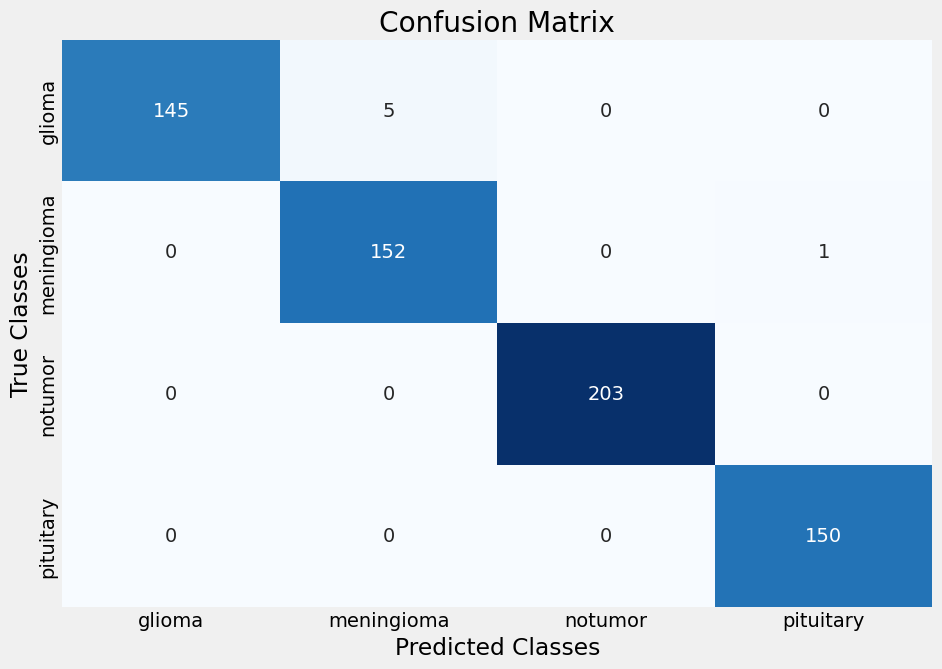

In [ ]:
# Get class names
class_names = list(test_gen_flow_data.class_indices.keys())
# Generate the confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

# Classification Report

In [ ]:
# Generate the classification report
report = classification_report(test_true_classes, test_pred_classes)

# Display the classification report
print(report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       150
           1       0.97      0.99      0.98       153
           2       1.00      1.00      1.00       203
           3       0.99      1.00      1.00       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



# ROC Curve

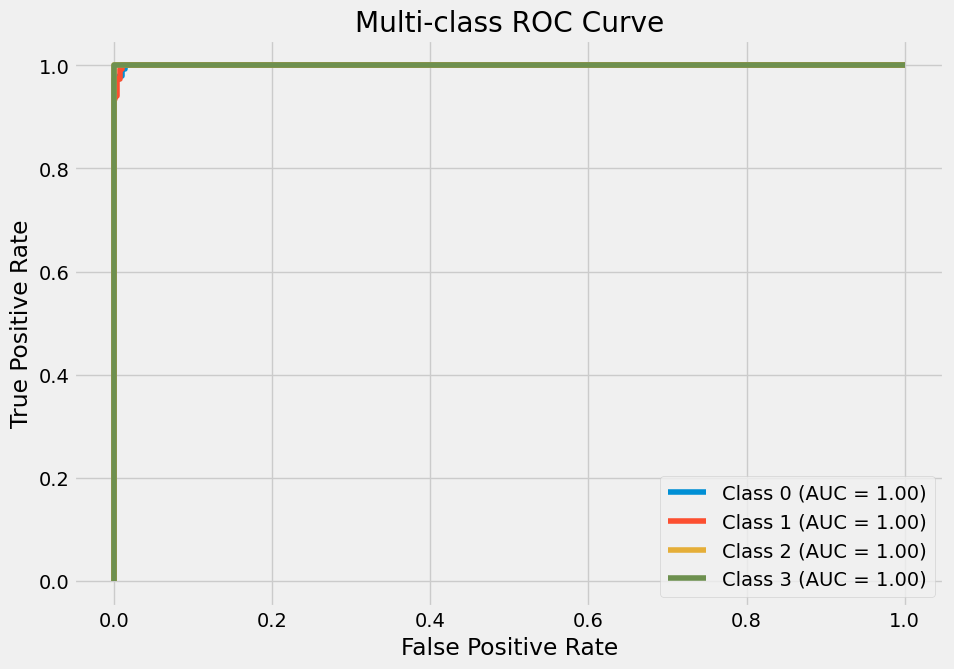

In [ ]:
# Assuming you have the true labels and predicted probabilities
n_classes = test_pred.shape[1]  # Number of classes

# Binarize the true labels for multi-class ROC curve
test_true_binarized = label_binarize(test_true_classes, classes=range(n_classes))

# Plot the ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_binarized[:, i], test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'Class {i}').plot(ax=plt.gca())

plt.title('Multi-class ROC Curve')
plt.show()

# Save the model

In [ ]:
model.save('/content/drive/MyDrive/TL_my_Best_01.h5')